<a href="https://colab.research.google.com/github/ommusuc/water-air/blob/main/last_homework/day1_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実践演習 Day 1：streamlitとFastAPIのデモ
このノートブックでは以下の内容を学習します。

- 必要なライブラリのインストールと環境設定
- Hugging Faceからモデルを用いたStreamlitのデモアプリ
- FastAPIとngrokを使用したAPIの公開方法

演習を始める前に、HuggingFaceとngrokのアカウントを作成し、
それぞれのAPIトークンを取得する必要があります。


演習の時間では、以下の3つのディレクトリを順に説明します。

1. 01_streamlit_UI
2. 02_streamlit_app
3. 03_FastAPI

2つ目や3つ目からでも始められる様にノートブックを作成しています。

復習の際にもこのノートブックを役立てていただければと思います。

### 注意事項
「02_streamlit_app」と「03_FastAPI」では、GPUを使用します。

これらを実行する際は、Google Colab画面上のメニューから「編集」→ 「ノートブックの設定」

「ハードウェアアクセラレーター」の項目の中から、「T4 GPU」を選択してください。

このノートブックのデフォルトは「CPU」になっています。

---

# 環境変数の設定（1~3共有）


GitHubから演習用のコードをCloneします。

In [1]:
!git clone https://github.com/ommusuc/water-air.git

Cloning into 'water-air'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 41 (delta 14), reused 38 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 44.73 KiB | 11.18 MiB/s, done.
Resolving deltas: 100% (14/14), done.


必要なAPIトークンを.envに設定します。

「lecture-ai-engineering/day1」の配下に、「.env_template」ファイルが存在しています。

隠しファイルのため表示されていない場合は、画面左側のある、目のアイコンの「隠しファイルの表示」ボタンを押してください。

「.env_template」のファイル名を「.env」に変更します。「.env」ファイルを開くと、以下のような中身になっています。


```
HUGGINGFACE_TOKEN="hf-********"
NGROK_TOKEN="********"
```
ダブルクオーテーションで囲まれた文字列をHuggingfaceのアクセストークンと、ngrokの認証トークンで書き変えてください。

それぞれのアカウントが作成済みであれば、以下のURLからそれぞれのトークンを取得できます。

- Huggingfaceのアクセストークン
https://huggingface.co/docs/hub/security-tokens

- ngrokの認証トークン
https://dashboard.ngrok.com/get-started/your-authtoken

書き換えたら、「.env」ファイルをローカルのPCにダウンロードしてください。

「01_streamlit_UI」から「02_streamlit_app」へ進む際に、CPUからGPUの利用に切り替えるため、セッションが一度切れてしまいます。

その際に、トークンを設定した「.env」ファイルは再作成することになるので、その手間を減らすために「.env」ファイルをダウンロードしておくと良いです。

「.env」ファイルを読み込み、環境変数として設定します。次のセルを実行し、最終的に「True」が表示されていればうまく読み込めています。

In [2]:
!pip install python-dotenv
from dotenv import load_dotenv, find_dotenv

%cd /content/water-air/last_homework
load_dotenv(find_dotenv())

/content/water-air/last_homework


True

# 02_streamlit_app


ディレクトリ「02_streamlit_app」に移動します。

In [3]:
%cd /content/water-air/last_homework/01_streamlit_UI

/content/water-air/last_homework/01_streamlit_UI


必要なライブラリをインストールします。

In [4]:
%%capture
!pip install -r requirements.txt

ngrokとhuggigfaceのトークンを使用して、認証を行います。

In [5]:
!ngrok authtoken $$NGROK_TOKEN
!huggingface-cli login --token $$HUGGINGFACE_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `dl_class` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `dl_class`


stramlitでHuggingfaceのトークン情報を扱うために、streamlit用の設定ファイル（.streamlit）を作成し、トークンの情報を格納します。

In [6]:
# .streamlit/secrets.toml ファイルを作成
import os
import toml

# 設定ファイルのディレクトリ確保
os.makedirs('.streamlit', exist_ok=True)

# 環境変数から取得したトークンを設定ファイルに書き込む
secrets = {
    "huggingface": {
        "token": os.environ.get("HUGGINGFACE_TOKEN", "")
    }
}

# 設定ファイルを書き込む
with open('.streamlit/secrets.toml', 'w') as f:
    toml.dump(secrets, f)

アプリを起動します。

02_streamlit_appでは、Huggingfaceからモデルをダウンロードするため、初回起動には2分程度時間がかかります。

この待ち時間を利用して、app.pyのコードを確認してみましょう。

# モデルを変更


```
google/gemma-3-4b-it
```

でconfig.pyでMODEL_NAMEを指定



## Gemma 3 モデルの概要


### 128,000 トークンのコンテキスト ウィンドウ

Gemma 3 モデルは、最大 128, 000 トークンのプロンプト入力を処理できます。これは、以前の Gemma モデルのコンテキスト ウィンドウの 16 倍です。トークンが大量にあるため、複数の複数ページの記事、大規模な単一の記事、数百枚の画像を 1 つのプロンプトで処理できます。




### パラメータのサイズと量子化

Gemma 3 モデルは、32 ビットのフル精度から 4 ビットの最小精度まで、5 つの精度レベルで 4 つのパラメータ サイズで使用できます。さまざまなサイズと精度は、AI アプリケーションのトレードオフを表します。パラメータとビット数が多いモデル（精度が高いモデル）は一般に機能が優れていますが、処理サイクル、メモリコスト、消費電力という点で実行コストが高くなります。パラメータとビット数が少ないモデル（精度が低いモデル）は機能が制限されますが、AI タスクに十分な場合があります。次の表に、Gemma 3 モデル バージョンの各サイズで推論を実行するために必要な GPU または TPU のメモリの概要を示します。


### 参照リンク先

https://ai.google.dev/gemma/docs/core?hl=ja




In [7]:
from pyngrok import ngrok

public_url = ngrok.connect(8501).public_url
print(f"公開URL: {public_url}")
!streamlit run app.py

公開URL: https://0723-35-186-152-117.ngrok-free.app



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.186.152.117:8501



2025-06-15 04:18:24.732957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 04:18:24.751259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749961104.775636    4138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749961104.783080    4138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 04:18:24.807900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

  Stopping...
  Stopping...


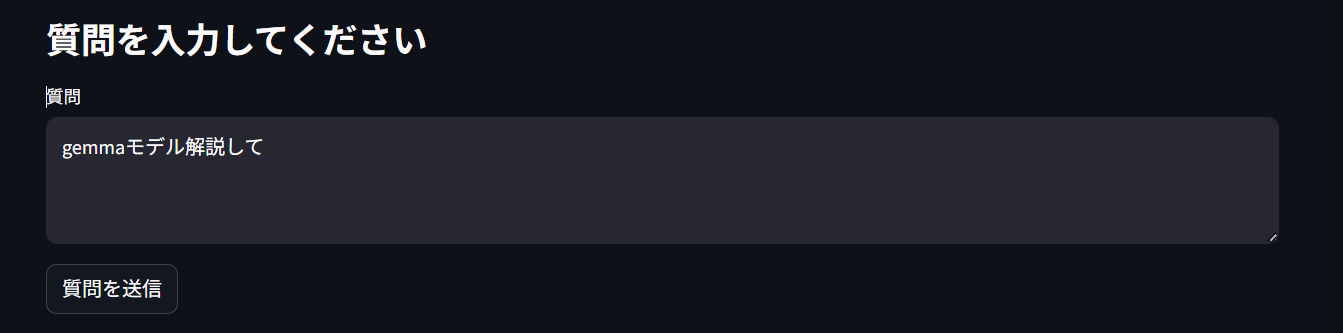

## 回答:
Gemmaは、Googleが開発した大規模言語モデル（LLM）です。2022年、Gemmaはオープンソースで公開され、研究や開発コミュニティに広く提供されました。以下に、Gemmaの主要な特徴と解説をまとめます。

## 1. Gemmaの概要

- 開発元: Google DeepMind
- モデルサイズ: 2B、7B、13Bパラメータ
- 学習データ: 大量のテキストとコードデータセット
- オープンアクセス: 研究目的や開発用途に利用可能
- 目的: 自然言語処理タスク（質問応答、テキスト生成、翻訳など）の性能向上

## 2. Gemmaの特徴

- 高品質なテキスト生成: 様々なトピックに関する創造的で正確なテキストを生成できます。

- 幅広いタスクに対応: 質問応答、要約、翻訳、コード生成など、多様なタスクに対応できます。

- オープンソース: 誰でも自由に利用、研究、開発に利用できます。

- 低コスト: モデルの利用には、計算資源やデータなど、ある程度のコストがかかりますが、比較的に低コストで利用できます。

- 多様なモデルサイズ: 2B、7B、13Bの3つのモデルサイズを提供しており、用途に合わせて選択できます。

## 3. Gemmaの仕組み

Gemmaは、Transformerアーキテクチャに基づいた大規模言語モデルです。具体的には、以下の点が特徴です。

- Mixture of Experts (MoE): モデルの性能を向上させるために、複数の「専門家」を組み合わせる技術です。

- Sparse Attention: TransformerのAttentionメカニズムの効率化を図り、計算コストを削減しています。

## 4. Gemmaの活用例

- チャットボット: ユーザーの質問に答えるチャットボットを構築できます。

- コンテンツ作成: ブログ記事、メール、レポートなどのコンテンツを生成できます。

- プログラミング: コードの生成、デバッグ、コードの説明など、プログラミングに役立てられます。

- 教育: 質問応答システム、教材作成、学習支援など、教育分野での活用が期待されています。

5. Gemmaのダウンロードと利用

- Google AI Studio: Gemmaを直接利用できるウェブベースのインターフェースです。
Hugging Face:

--------------------------------------------------------------------------------



アプリケーションの機能としては、チャット機能や履歴閲覧があります。

これらの機能を実現するためには、StreamlitによるUI部分だけではなく、SQLiteを使用したチャット履歴の保存やLLMのモデルを呼び出した推論などの処理を組み合わせることで実現しています。

- **`app.py`**: アプリケーションのエントリーポイント。チャット機能、履歴閲覧、サンプルデータ管理のUIを提供します。
- **`ui.py`**: チャットページや履歴閲覧ページなど、アプリケーションのUIロジックを管理します。
- **`llm.py`**: LLMモデルのロードとテキスト生成を行うモジュール。
- **`database.py`**: SQLiteデータベースを使用してチャット履歴やフィードバックを保存・管理します。
- **`metrics.py`**: BLEUスコアやコサイン類似度など、回答の評価指標を計算するモジュール。
- **`data.py`**: サンプルデータの作成やデータベースの初期化を行うモジュール。
- **`config.py`**: アプリケーションの設定（モデル名やデータベースファイル名）を管理します。
- **`requirements.txt`**: このアプリケーションを実行するために必要なPythonパッケージ。

後片付けとして、使う必要のないngrokのトンネルを削除します。

In [ ]:
from pyngrok import ngrok
ngrok.kill()

# 03_FastAPI

ディレクトリ「03_FastAPI」に移動します。

In [ ]:
%cd /content/lecture-ai-engineering/day1/03_FastAPI

/content/lecture-ai-engineering/day1/03_FastAPI


必要なライブラリをインストールします。

In [ ]:
%%capture
!pip install -r requirements.txt

ngrokとhuggigfaceのトークンを使用して、認証を行います。

In [ ]:
!ngrok authtoken $$NGROK_TOKEN
!huggingface-cli login --token $$HUGGINGFACE_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `dl_class` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `dl_class`


アプリを起動します。

「02_streamlit_app」から続けて「03_FastAPI」を実行している場合は、モデルのダウンロードが済んでいるため、すぐにサービスが立ち上がります。

「03_FastAPI」のみを実行している場合は、初回の起動時にモデルのダウンロードが始まるので、モデルのダウンロードが終わるまで数分間待ちましょう。

In [ ]:
!python app.py

2025-04-28 23:49:05.482972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745884145.697060    4164 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745884145.759089    4164 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 23:49:06.214638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
モデル名を設定: google/gemma-2-2b-jpn-it
/content/lecture-ai-engineering/day1/03_FastAPI/app.py:134: DeprecationWarning: 
  

FastAPIが起動すると、APIとクライアントが通信するためのURL（エンドポイント）が作られます。

URLが作られるのと合わせて、Swagger UIというWebインターフェースが作られます。

Swagger UIにアクセスすることで、APIの仕様を確認できたり、APIをテストすることができます。

Swagger UIを利用することで、APIを通してLLMを動かしてみましょう。

後片付けとして、使う必要のないngrokのトンネルを削除します。

In [ ]:
from pyngrok import ngrok
ngrok.kill()